In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.unicode_minus'] = False  



In [2]:
files = {
    2021: "KC_618_LLR_RSTRT_CNBAS_TRND_2021.csv",
    2022: "KC_618_LLR_RSTRT_CNBAS_TRND_2022.csv",
    2023: "KC_618_LLR_RSTRT_CNBAS_TRND_2023.csv",
    2024: "KC_618_LLR_RSTRT_CNBAS_TRND_2024.csv"
}

dfs = []
for year, file in files.items():
    df = pd.read_csv(file, encoding="utf-8")  
    df['year'] = year
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [46]:
print(data.shape)
print(data.columns.tolist())
print(data.head())

(326826, 11)
['CTPRVN_NM', 'SIGNGU_NM', 'ADSTRD_CD', 'FOOD_FCLTY_CD', 'FOOD_FCLTY_NM', 'CL_CD', 'FOOD_FCLTY_CO', 'POPLTN_CO', 'FILE_NM', 'BASE_DE', 'year']
  CTPRVN_NM SIGNGU_NM   ADSTRD_CD  FOOD_FCLTY_CD          FOOD_FCLTY_NM  \
0       강원도       춘천시  4211025000        56193.0                 치킨 전문점   
1       강원도       춘천시  4211025000        56193.0                 치킨 전문점   
2       강원도       춘천시  4211025000        56192.0  피자,햄버거,샌드위치 및 유사 읍식점업   
3       강원도       춘천시  4211025000        56111.0                     한식   
4       강원도       춘천시  4211025000        56111.0                     한식   

   CL_CD  FOOD_FCLTY_CO  POPLTN_CO                           FILE_NM  \
0  80609              1     282714  KC_618_LLR_RSTRT_CNBAS_TRND_2021   
1  80615              6     282714  KC_618_LLR_RSTRT_CNBAS_TRND_2021   
2  80616              2     282714  KC_618_LLR_RSTRT_CNBAS_TRND_2021   
3  81001             62     282714  KC_618_LLR_RSTRT_CNBAS_TRND_2021   
4  81004              6     28271

In [47]:
print(data.info())
print(data.describe(include='all').T.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CTPRVN_NM      326826 non-null  object 
 1   SIGNGU_NM      325130 non-null  object 
 2   ADSTRD_CD      326826 non-null  int64  
 3   FOOD_FCLTY_CD  325127 non-null  float64
 4   FOOD_FCLTY_NM  325127 non-null  object 
 5   CL_CD          326826 non-null  int64  
 6   FOOD_FCLTY_CO  326826 non-null  int64  
 7   POPLTN_CO      326826 non-null  int64  
 8   FILE_NM        326826 non-null  object 
 9   BASE_DE        326826 non-null  int64  
 10  year           326826 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 27.4+ MB
None
                  count unique                               top    freq  \
CTPRVN_NM        326826     19                               경기도   66268   
SIGNGU_NM        325130    231                                서구   10188   
ADSTRD_C

# 주요지표

In [48]:
data['restaurant_density'] = data['FOOD_FCLTY_CO'] / data['POPLTN_CO'] * 1000  

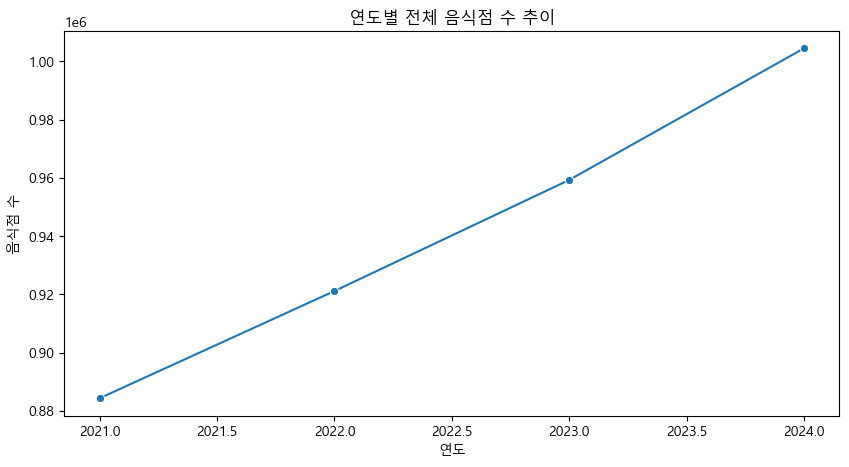

In [49]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby('year')['FOOD_FCLTY_CO'].sum().reset_index(),
    x='year', y='FOOD_FCLTY_CO', marker="o"
)
plt.title("연도별 전체 음식점 수 추이")
plt.xlabel("연도")
plt.ylabel("음식점 수")
plt.show()

In [50]:
# RFM 분석 및 클러스터링

# 지역별 데이터 집계 (시군구 단위)
regional_yearly = data.groupby(['CTPRVN_NM', 'SIGNGU_NM', 'year']).agg({
    'FOOD_FCLTY_CO': 'sum',
    'POPLTN_CO': 'mean',
    'restaurant_density': 'mean'
}).reset_index()

print(f"집계 데이터 크기: {regional_yearly.shape}")
print(f"분석 지역 수: {regional_yearly.groupby(['CTPRVN_NM', 'SIGNGU_NM']).ngroups}")

# RFM 지표 직접 계산

# 각 지역의 2024년 데이터 (최신)
latest_data = regional_yearly[regional_yearly['year'] == 2024].copy()

# 각 지역의 2023년 데이터 (성장률)
prev_data = regional_yearly[regional_yearly['year'] == 2023].copy()

# 2024년과 2023년 데이터 결합
merged_data = latest_data.merge(
    prev_data[['CTPRVN_NM', 'SIGNGU_NM', 'FOOD_FCLTY_CO']], 
    on=['CTPRVN_NM', 'SIGNGU_NM'], 
    how='left', 
    suffixes=('_2024', '_2023')
)

# R (Recency): 2023년 대비 2024년 성장률
merged_data['R_score'] = np.where(
    merged_data['FOOD_FCLTY_CO_2023'] > 0,
    ((merged_data['FOOD_FCLTY_CO_2024'] - merged_data['FOOD_FCLTY_CO_2023']) / 
     merged_data['FOOD_FCLTY_CO_2023'] * 100),
    0
)

# F (Frequency): 각 지역이 몇 년간 데이터를 가지고 있는지
frequency_data = regional_yearly.groupby(['CTPRVN_NM', 'SIGNGU_NM']).size().reset_index(name='F_score')
merged_data = merged_data.merge(frequency_data, on=['CTPRVN_NM', 'SIGNGU_NM'])

# M (Monetary): 2024년 음식점 밀도
merged_data['M_score'] = merged_data['restaurant_density']


집계 데이터 크기: (999, 6)
분석 지역 수: 287


In [51]:
# 최종 RFM 데이터셋
rfm_data = merged_data[['CTPRVN_NM', 'SIGNGU_NM', 'R_score', 'F_score', 'M_score', 
                       'FOOD_FCLTY_CO_2024', 'POPLTN_CO']].copy()
rfm_data.columns = ['region', 'district', 'R', 'F', 'M', 'total_restaurants', 'population']

print(f"RFM 데이터 크기: {rfm_data.shape}")
print("\nRFM 기본 통계:")
print(rfm_data[['R', 'F', 'M']].describe())

# 이상치 제거 (너무 극단적인 값들은 제거)
Q1_R = rfm_data['R'].quantile(0.25)
Q3_R = rfm_data['R'].quantile(0.75)
IQR_R = Q3_R - Q1_R
rfm_data = rfm_data[(rfm_data['R'] >= Q1_R - 1.5*IQR_R) & (rfm_data['R'] <= Q3_R + 1.5*IQR_R)]

print(f"이상치 제거 후 데이터 크기: {rfm_data.shape}")

# RFM 점수 표준화
scaler = StandardScaler()
rfm_data[['R_scaled', 'F_scaled', 'M_scaled']] = scaler.fit_transform(rfm_data[['R', 'F', 'M']])
print(rfm_data[['R_scaled', 'F_scaled', 'M_scaled']].describe())

RFM 데이터 크기: (251, 7)

RFM 기본 통계:
                R           F           M
count  251.000000  251.000000  251.000000
mean     4.055154    3.633466    0.141617
std      2.027296    0.903944    0.151192
min     -0.940089    1.000000    0.017689
25%      3.061635    4.000000    0.046261
50%      4.076252    4.000000    0.083053
75%      5.220064    4.000000    0.208529
max     15.789474    4.000000    1.454792
이상치 제거 후 데이터 크기: (247, 7)
           R_scaled      F_scaled      M_scaled
count  2.470000e+02  2.470000e+02  2.470000e+02
mean   3.308195e-16 -6.652348e-17 -1.851870e-16
std    1.002030e+00  1.002030e+00  1.002030e+00
min   -2.282130e+00 -2.893115e+00 -8.242767e-01
25%   -5.104781e-01  4.101180e-01 -6.360536e-01
50%    4.908797e-02  4.101180e-01 -3.757202e-01
75%    6.708856e-01  4.101180e-01  4.368268e-01
max    2.385235e+00  4.101180e-01  8.643016e+00


In [52]:

# 최적 클러스터 수 찾기
features = rfm_data[['R_scaled', 'F_scaled', 'M_scaled']]

inertias = []
silhouette_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))

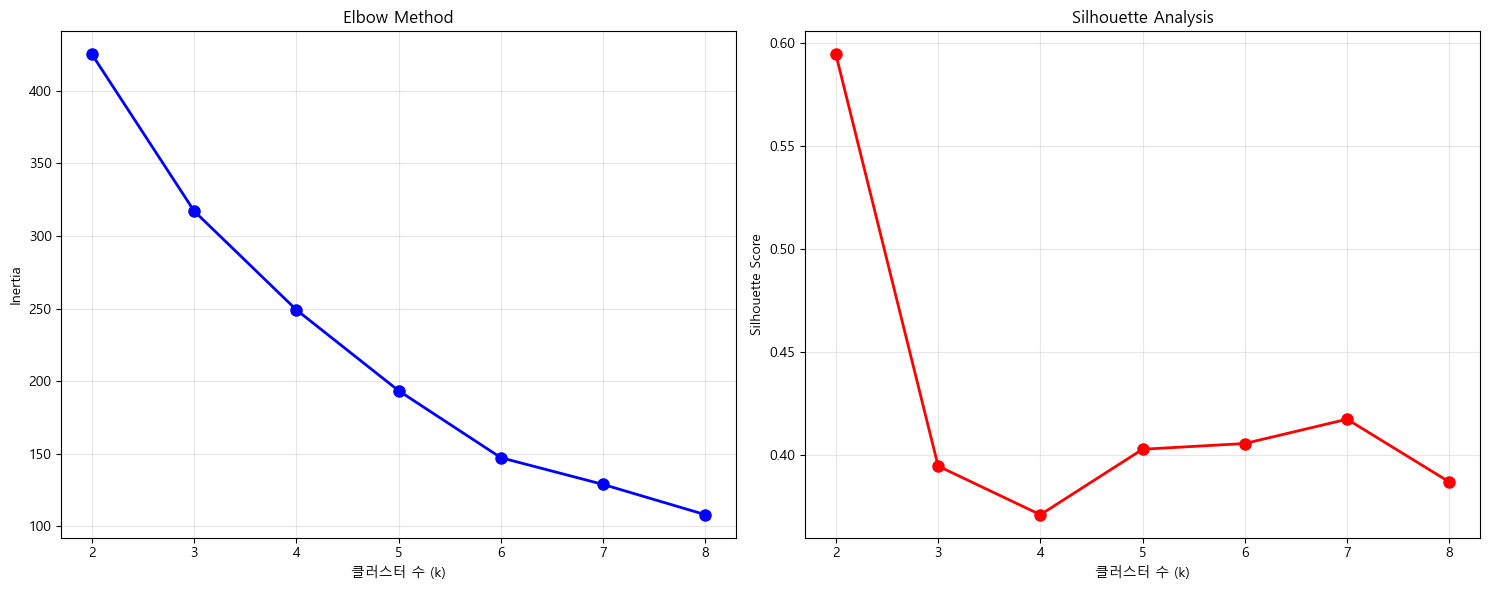

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('클러스터 수 (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('클러스터 수 (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# 최적 k 선택
best_k = K_range[np.argmax(silhouette_scores)]
print(f"최적 클러스터 수: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})")

# 최종 클러스터링
print(f"\n=== {best_k}개 클러스터로 분류 ===")
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm_data['cluster'] = final_kmeans.fit_predict(features)

# 클러스터별 특성 분석
cluster_summary = rfm_data.groupby('cluster').agg({
    'R': ['mean', 'count'],
    'F': 'mean', 
    'M': 'mean',
    'total_restaurants': 'mean',
    'population': 'mean'
}).round(2)

cluster_summary.columns = ['평균_성장률', '지역수', '평균_데이터년수', '평균_음식점밀도', 
                          '평균_음식점수', '평균_인구수']
print(cluster_summary)




최적 클러스터 수: 2 (Silhouette Score: 0.595)

=== 2개 클러스터로 분류 ===
         평균_성장률  지역수  평균_데이터년수  평균_음식점밀도  평균_음식점수     평균_인구수
cluster                                                     
0          1.73   38      1.68      0.29  2117.92   79892.95
1          4.40  209      3.98      0.12  4320.27  196483.84


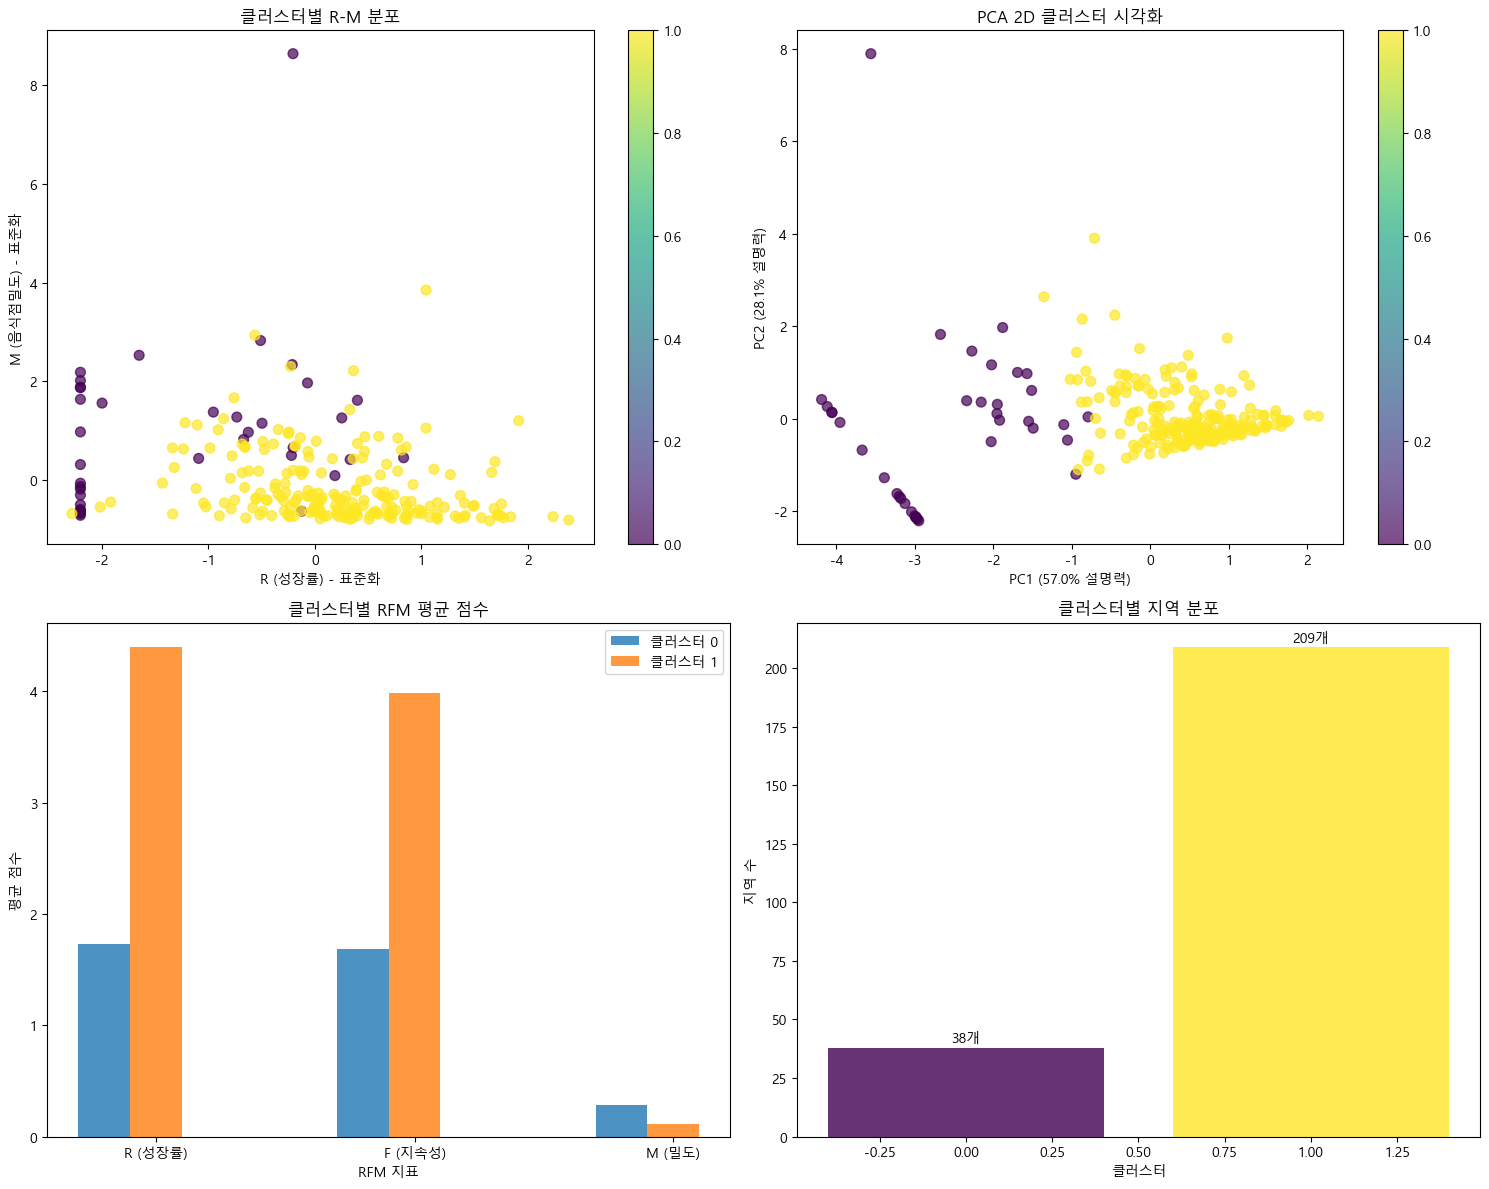


[클러스터 0] - 38개 지역
특성: 성장률 평균 1.7%, 밀도 평균 0.29
  - 경기도 부천시 원미구: 음식점 8151개, 성장률 0.0%
  - 전북특별자치도 전주시 완산구: 음식점 7436개, 성장률 0.0%
  - 강원특별자치도 춘천시: 음식점 6791개, 성장률 3.8%
  - 전북특별자치도 군산시: 음식점 6055개, 성장률 0.0%
  - 전북특별자치도 전주시 덕진구: 음식점 5812개, 성장률 0.0%

[클러스터 1] - 209개 지역
특성: 성장률 평균 4.4%, 밀도 평균 0.12
  - 서울특별시 강남구: 음식점 15146개, 성장률 3.5%
  - 경기도 화성시: 음식점 14752개, 성장률 8.3%
  - 제주특별자치도 제주시: 음식점 12366개, 성장률 -0.1%
  - 경상남도 김해시: 음식점 12184개, 성장률 4.1%
  - 경기도 평택시: 음식점 11252개, 성장률 8.0%


In [55]:

# 클러스터 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RFM 3D 산점도를 2D로 표현
ax1 = axes[0,0]
scatter = ax1.scatter(rfm_data['R_scaled'], rfm_data['M_scaled'], 
                     c=rfm_data['cluster'], cmap='viridis', alpha=0.7, s=50)
ax1.set_xlabel('R (성장률) - 표준화')
ax1.set_ylabel('M (음식점밀도) - 표준화')
ax1.set_title('클러스터별 R-M 분포')
plt.colorbar(scatter, ax=ax1)

# PCA 2D 시각화
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
ax2 = axes[0,1]
scatter2 = ax2.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=rfm_data['cluster'], cmap='viridis', alpha=0.7, s=50)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} 설명력)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} 설명력)')
ax2.set_title('PCA 2D 클러스터 시각화')
plt.colorbar(scatter2, ax=ax2)

# 클러스터별 평균 RFM 점수
cluster_means = rfm_data.groupby('cluster')[['R', 'F', 'M']].mean()
ax3 = axes[1,0]
x = np.arange(len(cluster_means.columns))
width = 0.2
for i, cluster in enumerate(cluster_means.index):
    ax3.bar(x + i*width, cluster_means.loc[cluster], width, 
           label=f'클러스터 {cluster}', alpha=0.8)
ax3.set_xlabel('RFM 지표')
ax3.set_ylabel('평균 점수')
ax3.set_title('클러스터별 RFM 평균 점수')
ax3.set_xticks(x + width)
ax3.set_xticklabels(['R (성장률)', 'F (지속성)', 'M (밀도)'])
ax3.legend()

# 8-4. 클러스터별 지역 수
ax4 = axes[1,1]
cluster_counts = rfm_data['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))
bars = ax4.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8)
ax4.set_xlabel('클러스터')
ax4.set_ylabel('지역 수')
ax4.set_title('클러스터별 지역 분포')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}개', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 각 클러스터의 대표 지역
for cluster_id in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    print(f"\n[클러스터 {cluster_id}] - {len(cluster_data)}개 지역")
    print(f"특성: 성장률 평균 {cluster_data['R'].mean():.1f}%, " + 
          f"밀도 평균 {cluster_data['M'].mean():.2f}")
    
    # 상위 5개 지역
    top_regions = cluster_data.nlargest(5, 'total_restaurants')
    for _, region in top_regions.iterrows():
        print(f"  - {region['region']} {region['district']}: " + 
              f"음식점 {region['total_restaurants']:.0f}개, " +
              f"성장률 {region['R']:.1f}%")

In [56]:
# 클러스터 특성 해석
for cluster_id in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    avg_r = cluster_data['R'].mean()
    avg_f = cluster_data['F'].mean()
    avg_m = cluster_data['M'].mean()
    print(f"\n클러스터 {cluster_id}:")
    
    # 성장률 기준
    if avg_r > 5:
        growth_type = "고성장"
    elif avg_r > 0:
        growth_type = "안정성장"
    else:
        growth_type = "성장둔화"
    
    # 밀도 기준  
    if avg_m > rfm_data['M'].quantile(0.75):
        density_type = "고밀도"
    elif avg_m > rfm_data['M'].median():
        density_type = "중밀도"
    else:
        density_type = "저밀도"
    
    print(f"  타입: {growth_type} + {density_type} 지역")
    print(f"  지역수: {len(cluster_data)}개")
    print(f"  평균 성장률: {avg_r:.1f}%")
    print(f"  평균 음식점 밀도: {avg_m:.2f}")


클러스터 0:
  타입: 안정성장 + 고밀도 지역
  지역수: 38개
  평균 성장률: 1.7%
  평균 음식점 밀도: 0.29

클러스터 1:
  타입: 안정성장 + 중밀도 지역
  지역수: 209개
  평균 성장률: 4.4%
  평균 음식점 밀도: 0.12


=== 클러스터 재명명 결과 ===
클러스터 0 - 포화형 소도시: 38개 지역
클러스터 1 - 성장형 대도시: 209개 지역

=== 상세 클러스터 분석 ===
                         R                      F           M              \
                      mean   std   min  max  mean   std  mean   std   min   
cluster cluster_name                                                        
0       포화형 소도시       1.73  1.89  0.00  5.5  1.68  0.84  0.29  0.25  0.03   
1       성장형 대도시       4.40  1.47 -0.15  8.3  3.98  0.20  0.12  0.11  0.02   

                           total_restaurants                  population  \
                       max              mean      std     sum       mean   
cluster cluster_name                                                       
0       포화형 소도시       1.45           2117.92  2126.80   80481   79892.95   
1       성장형 대도시       0.73           4320.27  2881.55  902936  196483.84   

                                  
                             sum  
cluster cluster_name              
0       포화형 소도시        3035932.0  
1 

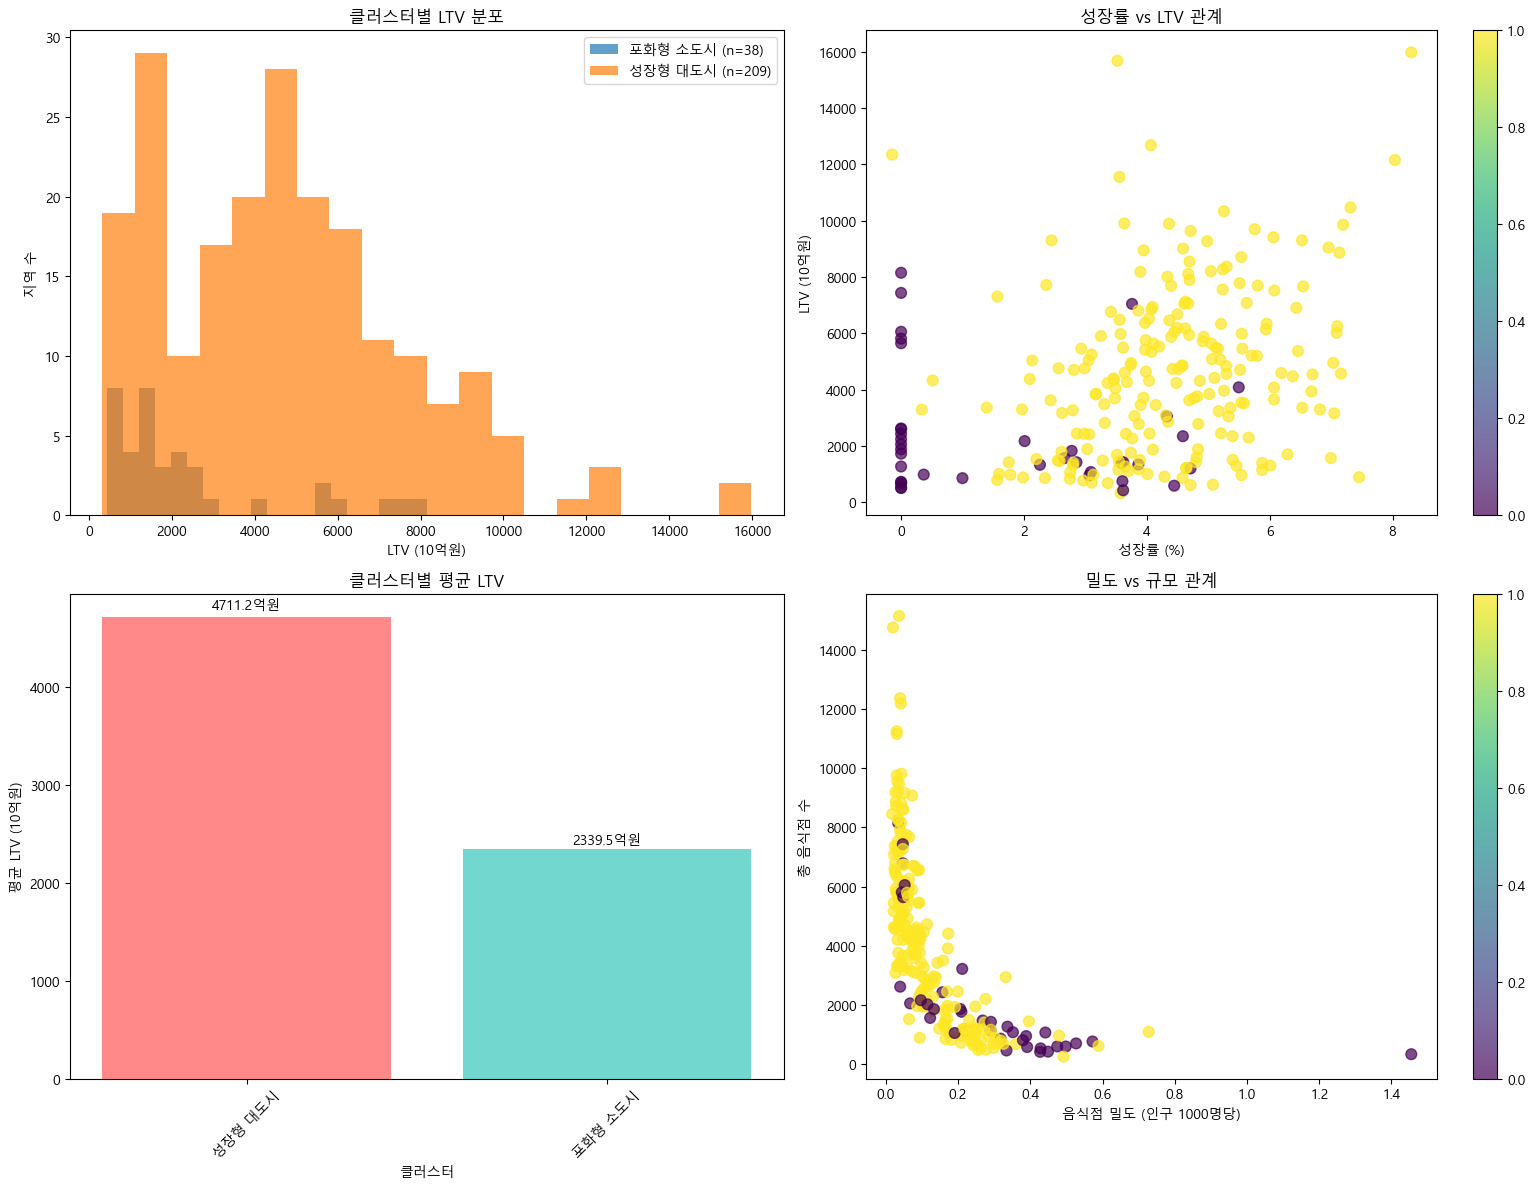

In [57]:
# 마케팅 전략 및 LTV 분석

# 1. 클러스터 명명 및 특성 정의
cluster_names = {
    0: "포화형 소도시",  # 고밀도, 저성장
    1: "성장형 대도시"   # 저밀도, 고성장
}

rfm_data['cluster_name'] = rfm_data['cluster'].map(cluster_names)

print("=== 클러스터 재명명 결과 ===")
for cluster_id, name in cluster_names.items():
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    print(f"클러스터 {cluster_id} - {name}: {len(cluster_data)}개 지역")

# 2. 상세 클러스터 분석
print("\n=== 상세 클러스터 분석 ===")

# 클러스터별 세부 통계
detailed_stats = rfm_data.groupby(['cluster', 'cluster_name']).agg({
    'R': ['mean', 'std', 'min', 'max'],
    'F': ['mean', 'std'],  
    'M': ['mean', 'std', 'min', 'max'],
    'total_restaurants': ['mean', 'std', 'sum'],
    'population': ['mean', 'sum']
}).round(2)

print(detailed_stats)

# 3. 지역별 포텐셜 점수 계산
print("\n=== 지역별 포텐셜 점수 계산 ===")

# 종합 점수 = (성장률 * 0.4) + (지속성 * 0.2) + (밀도 * 0.4)
rfm_data['potential_score'] = (
    rfm_data['R_scaled'] * 0.4 + 
    rfm_data['F_scaled'] * 0.2 + 
    rfm_data['M_scaled'] * 0.4
)

# 클러스터별 Top 10 잠재력 지역
print("\n클러스터별 높은 포텐셜 지역 TOP 10:")
for cluster_id in sorted(rfm_data['cluster'].unique()):
    print(f"\n[{cluster_names[cluster_id]}]")
    top_potential = rfm_data[rfm_data['cluster'] == cluster_id].nlargest(10, 'potential_score')
    for _, region in top_potential.iterrows():
        print(f"  {region['region']} {region['district']}: " +
              f"포텐셜 {region['potential_score']:.2f}, " +
              f"성장률 {region['R']:.1f}%, " +
              f"음식점 {region['total_restaurants']:.0f}개")

# 4. LTV (고객 생애 가치) 추정
# 가정: 
# - 음식점 1개당 연간 평균 매출 2억원
# - 음식점 평균 생존기간 5년
# - 지역별 성장률과 밀도를 고려한 가중치

avg_revenue_per_restaurant = 200_000_000  # 2억원
avg_lifespan = 5  # 5년

# LTV 계산: (현재 음식점 수 * 평균매출 * 생존기간) * (1 + 성장률/100) * 밀도가중치
rfm_data['density_weight'] = np.where(rfm_data['M'] > rfm_data['M'].median(), 1.2, 1.0)
rfm_data['growth_multiplier'] = 1 + (rfm_data['R'] / 100)

rfm_data['estimated_ltv'] = (
    rfm_data['total_restaurants'] * 
    avg_revenue_per_restaurant * 
    avg_lifespan * 
    rfm_data['growth_multiplier'] * 
    rfm_data['density_weight']
) / 1_000_000_000  # 10억원 단위

print("LTV 기본 통계 (단위: 10억원):")
print(rfm_data['estimated_ltv'].describe())

# 5. 클러스터별 LTV 분석
ltv_by_cluster = rfm_data.groupby(['cluster', 'cluster_name']).agg({
    'estimated_ltv': ['mean', 'sum', 'count'],
    'total_restaurants': 'sum',
    'population': 'sum'
}).round(2)

print(ltv_by_cluster)

# LTV 상위 지역
top_ltv_regions = rfm_data.nlargest(20, 'estimated_ltv')
for _, region in top_ltv_regions.iterrows():
    print(f"{region['region']} {region['district']}: " +
          f"LTV {region['estimated_ltv']:.1f}억원, " +
          f"클러스터: {region['cluster_name']}")

# 6. 시각화 - LTV 및 마케팅 인사이트
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 6-1. 클러스터별 LTV 분포
ax1 = axes[0,0]
for cluster_id in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    ax1.hist(cluster_data['estimated_ltv'], alpha=0.7, 
             label=f"{cluster_names[cluster_id]} (n={len(cluster_data)})",
             bins=20)
ax1.set_xlabel('LTV (10억원)')
ax1.set_ylabel('지역 수')
ax1.set_title('클러스터별 LTV 분포')
ax1.legend()

# 6-2. 성장률 vs LTV 산점도
ax2 = axes[0,1]
scatter = ax2.scatter(rfm_data['R'], rfm_data['estimated_ltv'], 
                     c=rfm_data['cluster'], cmap='viridis', alpha=0.7, s=60)
ax2.set_xlabel('성장률 (%)')
ax2.set_ylabel('LTV (10억원)')
ax2.set_title('성장률 vs LTV 관계')
plt.colorbar(scatter, ax=ax2)

# 6-3. 클러스터별 평균 LTV
ax3 = axes[1,0]
cluster_ltv_avg = rfm_data.groupby('cluster_name')['estimated_ltv'].mean()
colors = ['#FF6B6B', '#4ECDC4']
bars = ax3.bar(cluster_ltv_avg.index, cluster_ltv_avg.values, color=colors, alpha=0.8)
ax3.set_xlabel('클러스터')
ax3.set_ylabel('평균 LTV (10억원)')
ax3.set_title('클러스터별 평균 LTV')
ax3.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.1f}억원', ha='center', va='bottom')

# 6-4. 음식점 밀도 vs 총 음식점 수
ax4 = axes[1,1]
scatter2 = ax4.scatter(rfm_data['M'], rfm_data['total_restaurants'], 
                      c=rfm_data['cluster'], cmap='viridis', alpha=0.7, s=60)
ax4.set_xlabel('음식점 밀도 (인구 1000명당)')
ax4.set_ylabel('총 음식점 수')
ax4.set_title('밀도 vs 규모 관계')
plt.colorbar(scatter2, ax=ax4)

plt.tight_layout()
plt.show()


In [ ]:

# 7. 맞춤형 마케팅 전략 수립

strategies = {
    0: {
        "cluster_name": "포화형 소도시",
        "characteristics": [
            "음식점 밀도가 높음 (평균 0.29개/1000명)",
            "성장률이 상대적으로 낮음 (평균 1.7%)",
            "전주, 춘천, 군산 등 지방 중심도시",
            "시장 포화 상태"
        ],
        "strategies": [
            "기존 음식점 고도화 지원 (디지털 전환, 배달 시스템)",
            "차별화된 메뉴 개발 지원",
            "지역 특산품 활용 프로그램",
            "관광객 유치를 위한 지역 브랜딩",
            "소상공인 경영 컨설팅 제공"
        ],
        "budget_allocation": "30%",
        "roi_expectation": "안정적 수익, 장기적 관점"
    },
    1: {
        "cluster_name": "성장형 대도시", 
        "characteristics": [
            "높은 성장률 (평균 4.4%)",
            "상대적으로 낮은 밀도 (평균 0.12개/1000명)",
            "서울 강남, 화성, 평택 등 대도시/신도시",
            "확장 여지가 큰 시장"
        ],
        "strategies": [
            "신규 창업 지원 프로그램 집중",
            "프랜차이즈 확장 지원",
            "푸드테크 스타트업 육성",
            "대형 상권 개발 프로젝트",
            "배달 인프라 구축 투자"
        ],
        "budget_allocation": "70%",
        "roi_expectation": "고성장, 높은 수익성"
    }
}

for cluster_id, strategy in strategies.items():
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    total_ltv = cluster_data['estimated_ltv'].sum()
    avg_ltv = cluster_data['estimated_ltv'].mean()
    
    print(f"\n{strategy['cluster_name']} (클러스터 {cluster_id})")
    print("-" * 40)
    print(f"지역 수: {len(cluster_data)}개")
    print(f"총 LTV: {total_ltv:.1f}억원")
    print(f"평균 LTV: {avg_ltv:.1f}억원")
    print(f"예산 배분: {strategy['budget_allocation']}")
    
    print("\n주요 특성:")
    for char in strategy['characteristics']:
        print(f"  - {char}")
    
    print("\n권장 전략:")
    for i, strat in enumerate(strategy['strategies'], 1):
        print(f"  {i}. {strat}")
    
    print(f"\nROI 기대: {strategy['roi_expectation']}")

# 8. 투자 우선순위 지역 선정
# 투자 점수 = LTV * 성장률 가중치
rfm_data['investment_score'] = rfm_data['estimated_ltv'] * (1 + rfm_data['R']/100)

# 전체 투자 우선순위 TOP 15
print("\n투자 우선순위 TOP 15 지역:")
top_investment = rfm_data.nlargest(15, 'investment_score')
for i, region in enumerate(top_investment.iterrows(), 1):
    r = region[1]
    print(f"{i:2d}. {r['region']} {r['district']} ({r['cluster_name']})")
    print(f"     투자점수: {r['investment_score']:.1f}, LTV: {r['estimated_ltv']:.1f}억원, 성장률: {r['R']:.1f}%")

# 클러스터별 투자 우선순위
print("\n클러스터별 투자 우선순위:")
for cluster_id in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    top_5 = cluster_data.nlargest(5, 'investment_score')
    
    print(f"\n[{cluster_names[cluster_id]}] TOP 5:")
    for i, region in enumerate(top_5.iterrows(), 1):
        r = region[1]
        print(f"  {i}. {r['region']} {r['district']}: 투자점수 {r['investment_score']:.1f}")

# ROI 예측 모델

# 가정: 마케팅 투자 대비 수익률
marketing_investment_per_region = {
    0: 50_000_000,   # 포화형 소도시: 5천만원
    1: 100_000_000   # 성장형 대도시: 1억원
}

rfm_data['marketing_investment'] = rfm_data['cluster'].map(marketing_investment_per_region)

# 예상 추가 수익 = 투자금 * 성장률 * 지역 특성 가중치  
rfm_data['expected_additional_revenue'] = (
    rfm_data['marketing_investment'] * 
    (rfm_data['R'] / 100) * 
    rfm_data['density_weight'] * 
    3  # 3년간 효과 지속 가정
)

rfm_data['roi_ratio'] = (rfm_data['expected_additional_revenue'] / 
                        rfm_data['marketing_investment']) * 100

print("클러스터별 ROI 예측:")
roi_summary = rfm_data.groupby(['cluster', 'cluster_name']).agg({
    'marketing_investment': 'mean',
    'expected_additional_revenue': 'mean', 
    'roi_ratio': 'mean'
}).round(2)
print(roi_summary)

# 최종 마케팅 실행 계획
total_budget = 10_000_000_000  # 총 예산 100억원 가정

for cluster_id in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster_id]
    cluster_name = cluster_names[cluster_id]
    
    if cluster_id == 0:  # 포화형 소도시
        budget_ratio = 0.3
        target_regions = 15
    else:  # 성장형 대도시  
        budget_ratio = 0.7
        target_regions = 25
    
    cluster_budget = total_budget * budget_ratio
    budget_per_region = cluster_budget / target_regions
    
    print(f"\n{cluster_name}")
    print("-" * 40)
    print(f"총 배정 예산: {cluster_budget/100000000:.1f}억원 ({budget_ratio*100:.0f}%)")
    print(f"타겟 지역 수: {target_regions}개")
    print(f"지역당 예산: {budget_per_region/100000000:.1f}억원")
    
    # 해당 클러스터에서 투자 우선순위 상위 지역
    priority_regions = cluster_data.nlargest(target_regions, 'investment_score')
    expected_total_roi = priority_regions['expected_additional_revenue'].sum()
    
    print(f"예상 총 추가 수익: {expected_total_roi/100000000:.1f}억원")
    print(f"예상 ROI: {(expected_total_roi/cluster_budget)*100:.1f}%")
    
    print(f"\n우선 투자 대상 지역 TOP 10:")
    for i, region in enumerate(priority_regions.head(10).iterrows(), 1):
        r = region[1]
        print(f"  {i:2d}. {r['region']} {r['district']}: " +
              f"예상수익 {r['expected_additional_revenue']/100000000:.1f}억원")



포화형 소도시 (클러스터 0)
----------------------------------------
지역 수: 38개
총 LTV: 88902.0억원
평균 LTV: 2339.5억원
예산 배분: 30%

주요 특성:
  - 음식점 밀도가 높음 (평균 0.29개/1000명)
  - 성장률이 상대적으로 낮음 (평균 1.7%)
  - 전주, 춘천, 군산 등 지방 중심도시
  - 시장 포화 상태

권장 전략:
  1. 기존 음식점 고도화 지원 (디지털 전환, 배달 시스템)
  2. 차별화된 메뉴 개발 지원
  3. 지역 특산품 활용 프로그램
  4. 관광객 유치를 위한 지역 브랜딩
  5. 소상공인 경영 컨설팅 제공

ROI 기대: 안정적 수익, 장기적 관점

성장형 대도시 (클러스터 1)
----------------------------------------
지역 수: 209개
총 LTV: 984644.0억원
평균 LTV: 4711.2억원
예산 배분: 70%

주요 특성:
  - 높은 성장률 (평균 4.4%)
  - 상대적으로 낮은 밀도 (평균 0.12개/1000명)
  - 서울 강남, 화성, 평택 등 대도시/신도시
  - 확장 여지가 큰 시장

권장 전략:
  1. 신규 창업 지원 프로그램 집중
  2. 프랜차이즈 확장 지원
  3. 푸드테크 스타트업 육성
  4. 대형 상권 개발 프로젝트
  5. 배달 인프라 구축 투자

ROI 기대: 고성장, 높은 수익성

투자 우선순위 분석

투자 우선순위 TOP 15 지역:
 1. 경기도 화성시 (성장형 대도시)
     투자점수: 17303.5, LTV: 15976.9억원, 성장률: 8.3%
 2. 서울특별시 강남구 (성장형 대도시)
     투자점수: 16231.0, LTV: 15679.1억원, 성장률: 3.5%
 3. 경상남도 김해시 (성장형 대도시)
     투자점수: 13194.8, LTV: 12679.4억원, 성장률: 4.1%
 4. 경기도 평택시 (성장형 대도시)
     투자점수: 13133.2, LTV:

## 대시보드 요약지표

In [59]:
print("\n" + "="*60)
print("대시보드 요약 지표")
print("="*60)

summary_metrics = {
    "총 분석 지역 수": len(rfm_data),
    "총 예상 LTV": f"{rfm_data['estimated_ltv'].sum():.0f}억원",
    "평균 지역별 LTV": f"{rfm_data['estimated_ltv'].mean():.1f}억원",
    "고성장 지역 수": len(rfm_data[rfm_data['R'] > 5]),
    "고밀도 지역 수": len(rfm_data[rfm_data['M'] > rfm_data['M'].quantile(0.75)]),
    "투자 우선순위 1위": f"{top_investment.iloc[0]['region']} {top_investment.iloc[0]['district']}",
    "예상 전체 ROI": f"{(rfm_data['expected_additional_revenue'].sum() / (total_budget))*100:.1f}%"
}

for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")


대시보드 요약 지표
총 분석 지역 수: 247
총 예상 LTV: 1073546억원
평균 지역별 LTV: 4346.3억원
고성장 지역 수: 72
고밀도 지역 수: 62
투자 우선순위 1위: 경기도 화성시
예상 전체 ROI: 31.0%


In [60]:

output_file = "rfm_clustering_results.csv"
rfm_data.to_csv(output_file, encoding='utf-8-sig', index=False)
print(f"결과 저장: {output_file}")

결과 저장: rfm_clustering_results.csv
